# Product Recommender System for online Retail Business 

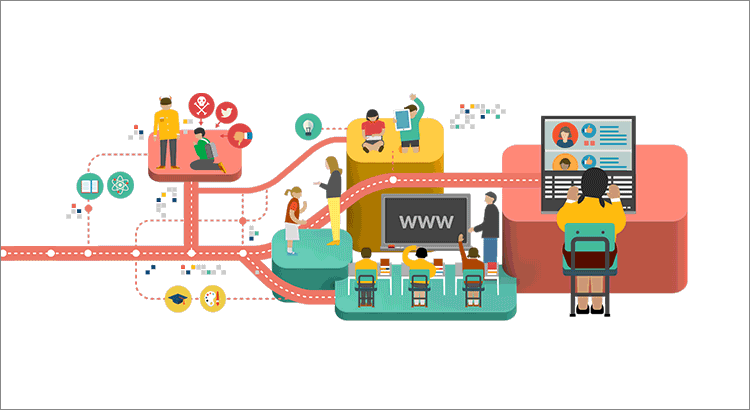

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import warnings
from matplotlib import font_manager as fm
from scipy.sparse import coo_matrix
from sklearn import preprocessing

In [3]:
# Set Display parameters
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [5]:
# Set Working directory
#os.chdir(r'C:\Users\SHALESH\Desktop\Final_Project _ML_Dataset')

## Read Datasets 

In [6]:
data1=pd.read_csv("category_tree.csv",na_values=[""," ","NA","N/A"])
data1.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


Category IDs explain the relationship of different products with each other e.g. Category ID 1016 is a child of Parent ID 213.

In [7]:
data2=pd.read_csv("events.csv",na_values=[""," ","NA","N/A"])
data2.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


- The timestamp portion is in Unix Epoch format e.g. 1433221332117 will be converted to Tuesday, 2 June 2015 5:02:12.117 AM GMT
- Visitor Id is the unique user currently browsing the website
- Event is what the user is currently doing in that current timestamp
- Transaction ID will only have value if the user made a purchase

In [8]:
data3=pd.read_csv("item_properties_part1.csv",na_values=[""," ","NA","N/A"])
data3.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [9]:
data3.shape

(10999999, 4)

In [10]:
data4=pd.read_csv("item_properties_part2.csv",na_values=[""," ","NA","N/A"])
data4.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [11]:
data4.shape

(9275903, 4)

In [12]:
# Appending the Item properties part 1 & 2 dataset together 
data=pd.concat([data3,data4])
data.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


- Timestamp is still the same Unix / Epoch format
- Item id will be the unique item identifier
- Property is the Item's attributes such as category id and availability while the rest are hashed for confidentiality purposes
- Value is the item's property value e.g. availability is 1 if there is stock and 0 otherwise
- Note: Values that start with "n" indicate that the value preceeding it is a number e.g. n277.200 is equal to 277.2

In [13]:
data.shape

(20275902, 4)

In [14]:
# Saving the appended file tothe same location
data.to_csv('data.csv')

### Data Dictionary & insights of some variables
Introduction 

Recommender systems are among the most popular applications of data science today. They are used to predict the "rating" or "preference" that a user would give to an item. It can be thought of as a subclass of information filtering system that seeks to predict the best “rating” or “preference” a user would give to an item which is typically obtained by optimizing for objectives like total clicks, total revenue, and overall sales.

The modelling approach relying on the former data are generally known Collaborative Filtering method, and approach using the later are referred to as Content Base Filtering method. There is also another category known as Knowledge-Based recommender system that is based on explicitly specified user requirements.


About the Dataset


The dataset consists of three files
1.Behaviour data (events.csv)
2.Item properties (itemproperties.сsv) 
3.category tree (categorytree.сsv). 

The data has been collected from a real-world ecommerce website. It is raw data, i.e. without any content transformations, however, all values are hashed due to confidential issues. 

This dataset is taken from https://www.kaggle.com/retailrocket/ecommerce-dataset/home

Dataset info:

* Behaviour data refers to events like clicks, add to carts, transactions, represent interactions that were collected over a period of 4.5 months.
* A visitor can make three types of events, namely “view”, “addtocart” or “transaction”. 
* In total, there are 2 756 101 events including 2 664 312 views, 69 332 add to carts and 22 457 transactions produced by 1 407 580 unique visitors. 
* For about 90% of events corresponding properties can be found in the “item_properties.csv” file. 
* The file with item properties (item_properties.csv) includes 20 275 902 rows, i.e. different properties, describing 417 053 unique items. File is divided into 2 files due to file size limitations. 
* Item properties file contain timestamp column because all of them are time dependent, since properties may change over time, e.g. price, category, etc
* The category tree file has 1669 rows. Every row in the file specifies a child category Id and the corresponding parent.
* Category IDs explain the relationship of different products with each other e.g. Category ID 1016 is a child of Parent ID 213.









## Part A

### Exploratory Data Analysis

#### 1. Convert the timeframe of datasets into readable format  

In [14]:
# Converting the time frame data to a readable format of time for item properties data
import datetime
times=[]
for i in data['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))

In [15]:
data['timestamp']=times
data.head()

,timestamp,itemid,property,value
0,2015-06-28 08:30:00,460429,categoryid,1338
1,2015-09-06 08:30:00,206783,888,1116713 960601 n277.200
2,2015-08-09 08:30:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 08:30:00,59481,790,n15360.000
4,2015-05-17 08:30:00,156781,917,828513


In [16]:
# Converting the time frame data to a readable format of time for both Events data
import datetime
times=[]
for i in data2['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i/1000.0))

In [17]:
data2['timestamp']=times
data2.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 10:32:12.117,257597,view,355908,NaN
1,2015-06-02 11:20:14.164,992329,view,248676,NaN
2,2015-06-02 10:43:19.827,111016,view,318965,NaN
3,2015-06-02 10:42:35.914,483717,view,253185,NaN
4,2015-06-02 10:32:17.106,951259,view,367447,NaN


#### 2. Checking the null values of the data

In [18]:
# Checking for item properties data
print(data.isnull().sum())
print('')
print(data.isnull().sum().sum())

timestamp    0
itemid       0
property     0
value        0
dtype: int64

0


In [19]:
### Get Descriptive statistics for clustering data
data.describe()  

,itemid
count,2.027590e+07
mean,2.333904e+05
std,1.348452e+05
min,0.000000e+00
25%,1.165160e+05
50%,2.334830e+05
75%,3.503040e+05
max,4.668660e+05


In [20]:
# Checking for events data
print(data1.isnull().sum())
print('')
print(data1.isnull().sum().sum())

categoryid     0
parentid      25
dtype: int64

25


In [21]:
data1.describe()

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


In [22]:
# Checking for events data
print(data2.isnull().sum())
print('')
print(data2.isnull().sum().sum())

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

2733644


#### 3. Making a copy of the dataset for all 3 final datasets

In [23]:
# Make a copy of datasets
data_ct=data1.copy()
data_ip=data.copy()
data_e=data2.copy()

In [24]:
data_ct.shape

(1669, 2)

In [25]:
data_e.shape

(2756101, 5)

In [26]:
data_ip.shape

(20275902, 4)

In [27]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()



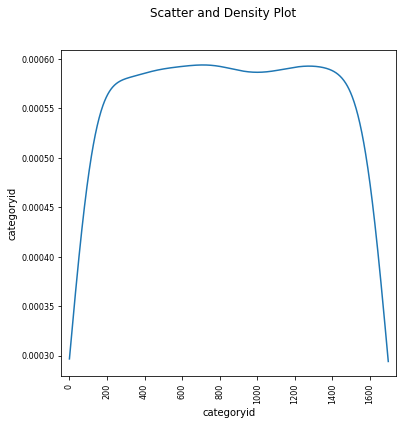

In [28]:
plotScatterMatrix(data1, 6, 15)

Events data

In [29]:
#Which event has a value in its transaction id ?
data_e[data_e.transactionid.notnull()].event.unique()

array(['transaction'], dtype=object)

The rest of the events with NaN transaction ids are either view or add to cart

In [30]:
#Which event/s has a null value ?
data_e[data_e.transactionid.isnull()].event.unique()

array(['view', 'addtocart'], dtype=object)

In [31]:
visitors=data_e["visitorid"].unique()
print('Total unique visitors :',data_e.shape)

Total unique visitors : (2756101, 5)


Unique visitors are almost half the number of total visitors

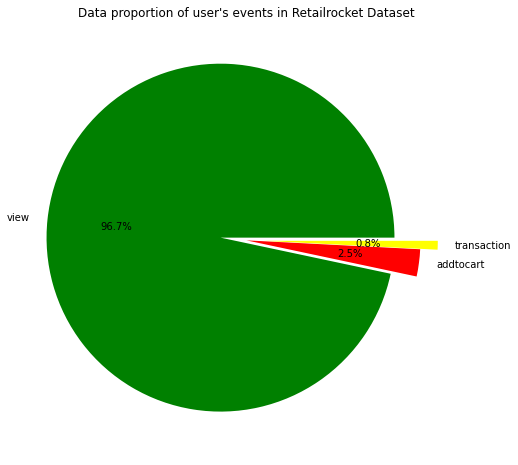

In [32]:
data = data_e.event.value_counts()
indexes = data.index
values = data.values
explode = (0.15, 0, 0.1)  
colors = ['green','red','yellow']
plt.subplots(figsize=(8,8))
# Plot
plt.pie(values, labels=indexes,startangle=0, autopct='%.1f%%', explode=explode,colors=colors)
 
plt.title("Data proportion of user's events in Retailrocket Dataset")
plt.show()

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Only 0.8% of visitors actually made the transaction </font> </i>
    </i></u></b> </font>

In [33]:
grouped=data_e.groupby('event')['itemid'].apply(list)

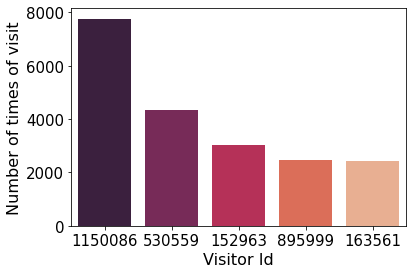

In [34]:
# Most active user(s)
import operator
import matplotlib as mpl
mpl.rcParams['font.size'] = 15.0
allevents=list(data_e['visitorid'])
count_allevents={}
allevents=np.array(allevents)
unique, counts = np.unique(allevents, return_counts=True)
count_allevents=dict(zip(unique, counts))
sorted_count_allevents =sorted(count_allevents.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_allevents[:5]]
y=[i[1] for i in sorted_count_allevents[:5]]
plt.xlabel('Visitor Id', fontsize=16)
plt.ylabel('Number of times of visit', fontsize=16)
g=sns.barplot(x,y, order=x)
sns.barplot(x, y, order=x, palette="rocket")

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Top 3 visitors in terms of activity are 1150086, 530559, 152963 </font> </i>
    </i></u></b> </font>

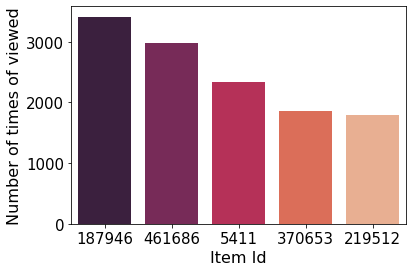

In [35]:
# Most active item(s) - items with maximum views, add to cart & transactions 
allevents=list(data_e['itemid'])
count_allevents={}
allevents=np.array(allevents)
unique, counts = np.unique(allevents, return_counts=True)
count_allevents=dict(zip(unique, counts))
sorted_count_allevents =sorted(count_allevents.items(), key=operator.itemgetter(1),reverse=True)
x=[i[0] for i in sorted_count_allevents[:5]]
y=[i[1] for i in sorted_count_allevents[:5]]
plt.xlabel('Item Id', fontsize=16)
plt.ylabel('Number of times of viewed', fontsize=16)
g=sns.barplot(x,y, order=x)
sns.barplot(x, y, order=x, palette="rocket")

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Top 3 products in terms of activity are 187946, 461686, 5411 </font> </i>
    </i></u></b> </font>

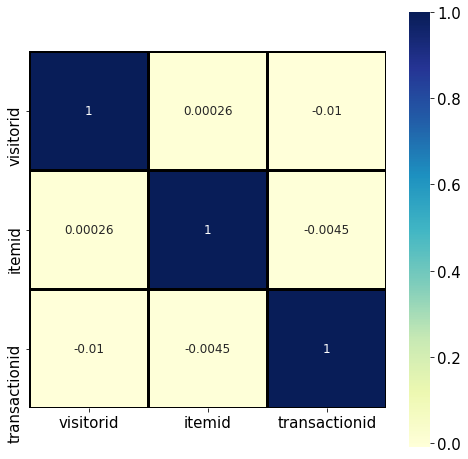

In [36]:
#correlation matrix
fig, axs = plt.subplots(nrows=1, figsize=(8,8))
sns.heatmap(data_e.corr(), annot=True, square=True, cmap='YlGnBu', linewidths=2, linecolor='black', annot_kws={'size':12})

In [37]:
# Frequency of appearance of items
items = data_e.itemid.value_counts()
for i in [2, 10, 50, 100, 1000]:
    print(f'Items that appear less than {i:>4} times:\
          {round((items < i).mean() * 100, 2)}%')
items.head(5)

Items that appear less than    2 times:          31.31%
Items that appear less than   10 times:          76.55%
Items that appear less than   50 times:          95.25%
Items that appear less than  100 times:          98.2%
Items that appear less than 1000 times:          99.98%


187946    3412
461686    2978
5411      2334
370653    1854
219512    1800
Name: itemid, dtype: int64

In [38]:
# Frequency of appearance of visitors
visitors = data_e.visitorid.value_counts()
for i in [2, 5, 10, 15]:
    print(f'Visitors that appear less than {i:>2} times:\
          {round((visitors < i).mean() * 100, 2):.02f}%')

visitors.head(5)

Visitors that appear less than  2 times:          71.15%
Visitors that appear less than  5 times:          94.20%
Visitors that appear less than 10 times:          98.35%
Visitors that appear less than 15 times:          99.20%


1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
Name: visitorid, dtype: int64

In [39]:
events=pd.read_csv("events.csv",na_values=[""," ","NA","N/A"])
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [40]:
data_ip.head()

,timestamp,itemid,property,value
0,2015-06-28 08:30:00,460429,categoryid,1338
1,2015-09-06 08:30:00,206783,888,1116713 960601 n277.200
2,2015-08-09 08:30:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 08:30:00,59481,790,n15360.000
4,2015-05-17 08:30:00,156781,917,828513


In [41]:
# Saving timestamp cloumn into a new dataframe to check occuring of events with the time of day
hour = lambda x: (datetime.datetime.fromtimestamp(x)-datetime.timedelta(hours=5)).hour
timestamp = events[['timestamp', 'event']].copy()
timestamp['timestamp'] = timestamp.timestamp / 1000
timestamp['hour'] = timestamp['timestamp'].apply(hour)

timestamp.head()

,timestamp,event,hour
0,1.433221e+09,view,5
1,1.433224e+09,view,6
2,1.433222e+09,view,5
3,1.433222e+09,view,5
4,1.433221e+09,view,5


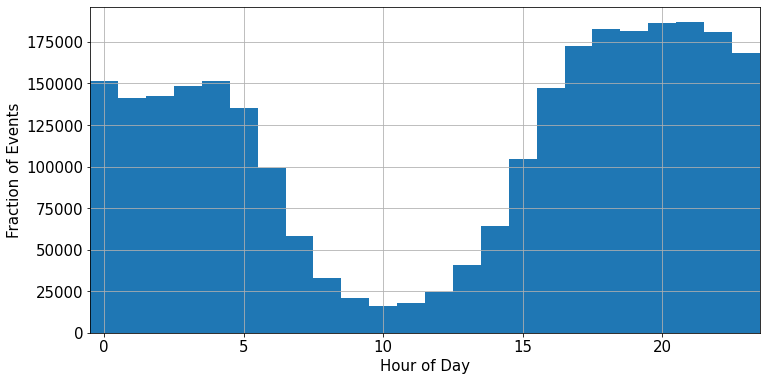

In [42]:
# Calculating the peek hours of events taking place
plt.figure(figsize=(12,6))
timestamp.hour.hist(bins=np.linspace(-0.5, 23.5, 25), alpha=1)
plt.xlim(-0.5, 23.5)
plt.xlabel("Hour of Day")
plt.ylabel("Fraction of Events")
plt.show()

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Highest no of events are occurring from 7 to 9 pm </font> </i>
    </i></u></b> </font>

In [43]:
# To check unique and total visitors from event datasets

# all unique visitors
all_customers = events['visitorid'].unique()
print("Unique visitors:", all_customers.size)

# all visitors
print('Total visitors:', events['visitorid'].size)

Unique visitors: 1407580
Total visitors: 2756101


In [44]:
# Calculating the number of customers who acutally bought something
customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

This shows that out of 1407580 unique visitors, 11719 visitors made at least a single purchase which means 0.83% of the customers made at least a single purchase purchase

In [45]:
# Create 10 samples, size 30 by simple random sampling

sp1 = events.sample(n = 100, random_state = 1)
sp2 = events.sample(n=100, random_state = 2)
sp3 = events.sample(n=100, random_state = 3)

# Create new column as named nitemid contain last-digit number of itemid numbers in each sample
sp1['nitemid'] =  (sp1['itemid']%10)
sp2['nitemid'] =  (sp2['itemid']%10)
sp3['nitemid'] =  (sp3['itemid']%10)

# Group 2 variable nitemid and event of each sample
sp1 = sp1.groupby(['nitemid','event']).size()
sp1 = sp1.unstack()
sp2 = sp2.groupby(['nitemid','event']).size()
sp2 = sp2.unstack()
sp3 = sp3.groupby(['nitemid','event']).size()
sp3 = sp3.unstack()

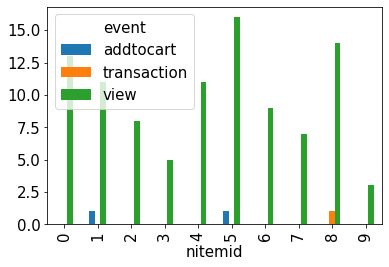

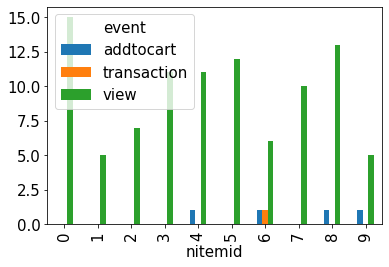

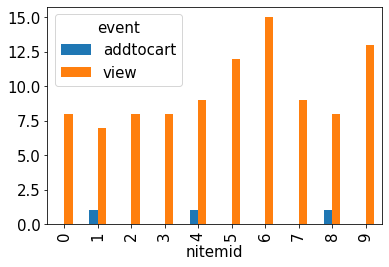

In [46]:
# Plot bar graph for each sample

sp1.plot(kind='bar')
sp2.plot(kind='bar')
sp3.plot(kind='bar')

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Each sample vary from each other in terms of the proportion of event types </font> </i>
    </i></u></b> </font>

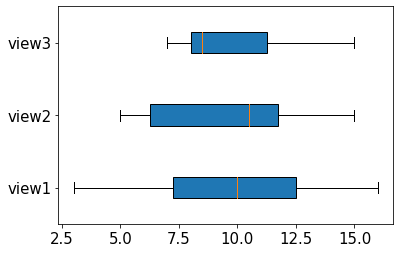

In [47]:

# Plot box plot of view of each sample

view1 = sp1['view']
view2 = sp2['view']
view3 = sp3['view']

allview = [view1, view2, view3]
box1 = plt.boxplot(allview,vert=0,patch_artist=True, 
                   labels = ['view1', 'view2', 'view3'])

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> View-2 has highest median volume and range of values are also higher </font> </i>
    </i></u></b> </font>

### Key Insights from EDA analysis
- Almost 2% of all users in event have bought some item.
- Almost 71% of users just viewed 1 item and left.
- Almost 54% of items were never viewed.

### Part B: 

#### (I) Content Based Filtering Recommended Engine

Low-rank matrix factorization of the user-item activity matrix (a matrix where each entry corresponds to how many times each user interacted with each item) that shares the same item-factor matrix above plus an offset based on user activity


In [48]:
events = pd.read_csv("events.csv")
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [49]:
events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In order to put all user-item interactions in one scale, we will arbitrarily assign values as follows:

View: +1
Add to basket: +3
Purchase: +3
Thus, if a user clicks an item, that (user, item) pair will have value=1, if they later adds it to cart and purchases it, will have value=7 (plus any other views of the same item), and so on.

The reasoning behind this scale is because the distributions of counts and sums of counts seem to still follow a nice exponential distribution with these values, but different values might give better results in terms of models fit to them.

We convert view events to 1, addtocart events to 2, and transaction events to 3 with the following code:

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Depending the level of activity shown by visitor, they are given values (See above for rule of thumb) </font> </i>
    </i></u></b> </font>

             timestamp  visitorid event  itemid  transactionid  count
0        1433221332117     257597  view  355908            NaN      1
1        1433224214164     992329  view  248676            NaN      1
2        1433221999827     111016  view  318965            NaN      1
3        1433221955914     483717  view  253185            NaN      1
4        1433221337106     951259  view  367447            NaN      1
...                ...        ...   ...     ...            ...    ...
2756096  1438398785939     591435  view  261427            NaN      1
2756097  1438399813142     762376  view  115946            NaN      1
2756098  1438397820527    1251746  view   78144            NaN      1
2756099  1438398530703    1184451  view  283392            NaN      1
2756100  1438400163914     199536  view  152913            NaN      1

[2756101 rows x 6 columns]


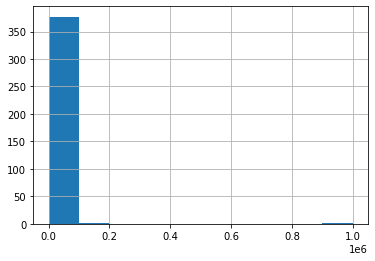

In [50]:
%matplotlib inline

equiv = {
    'view':1,
    'addtocart':3,
    'transaction':3
}
events['count']=events.event.map(equiv)

print(events)
events.groupby('visitorid')['count'].sum().value_counts().hist()

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [52]:
events = events.groupby(['visitorid','itemid'])['count'].sum().to_frame().reset_index()
events.rename(columns={'visitorid':'UserId', 'itemid':'ItemId', 'count':'Count'}, inplace=True)
events.head()

,UserId,ItemId,Count
0,0,67045,1
1,0,285930,1
2,0,357564,1
3,1,72028,1
4,2,216305,2


Now creating a train and test split. For simplicity purposes and in order to be able to make a fair comparison with a model that doesn't use item descriptions, we will try to only take users that had >= 3 items in the training data, and items that had >= 3 users.

Given the lack of user attributes and the fact that it will be compared later to a model without side information, the test set will only have users from the training data, but it's also possible to use user attributes if they follow the same format as the items', in which case the model can also recommend items to new users.

In order to compare it later to a model without items' text, we will also filter out the test set to have only items that were in the training set. This is however not a model limitation, as it can also recommend items that have descriptions but no user interactions.

In [53]:
# Fitting the data to the logistic model
X = events.drop(['Count'], axis = 'columns')
y = events.Count
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1, train_size = 0.2)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

g:\aws\envs\sallu\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [54]:
y_pred_class = logreg.predict(X_test)

In [55]:
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.8398


In [56]:
#Make class predictions.
predictions = logreg.predict(X_test)

In [57]:
#Calculate accuracy score.
logreg.score(X_test, y_test)

0.8398322052228717

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Model Accuracy is 84% </font> </i>
    </i></u></b> </font>

In [58]:
predictions = logreg.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

g:\aws\envs\sallu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.84      1.00      0.91   1441273
           2       0.00      0.00      0.00    159223
           3       0.00      0.00      0.00     45451
           4       0.00      0.00      0.00     25768
           5       0.00      0.00      0.00     11846
           6       0.00      0.00      0.00      7719
           7       0.00      0.00      0.00      8955
           8       0.00      0.00      0.00      5247
           9       0.00      0.00      0.00      3016
          10       0.00      0.00      0.00      1906
          11       0.00      0.00      0.00      1242
          12       0.00      0.00      0.00       890
          13       0.00      0.00      0.00       704
          14       0.00      0.00      0.00       539
          15       0.00      0.00      0.00       417
          16       0.00      0.00      0.00       322
          17       0.00      0.00      0.00       236
          18       0.00    

In [59]:
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
%matplotlib inline
confusion_matrix(y_test, predictions)

array([[1441273,       0,       0, ...,       0,       0,       0],
       [ 159223,       0,       0, ...,       0,       0,       0],
       [  45451,       0,       0, ...,       0,       0,       0],
       ...,
       [      1,       0,       0, ...,       0,       0,       0],
       [      1,       0,       0, ...,       0,       0,       0],
       [      1,       0,       0, ...,       0,       0,       0]],
      dtype=int64)

In [60]:
#processing the text descriptions of the items:
    
iteminfo = pd.read_csv("item_properties_part1.csv")
iteminfo2 = pd.read_csv("item_properties_part2.csv")
iteminfo = iteminfo.append(iteminfo2, ignore_index=True)
iteminfo.head()  


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


##### The item's description contain many fields and have a mixture of words and numbers. The numeric variables, as per the documentation, are prefixed with an "n" and have three digits decimal precision - we will exclude them here since this model is insensitive to numeric attributes such as price. The words are already lemmazed, and since we only have their IDs, it's not possible to do any other pre-processing on them.

In [61]:
iteminfo = iteminfo.loc[iteminfo.property.isin(('888','283'))]
iteminfo = iteminfo.loc[iteminfo.groupby(['itemid','property'])['timestamp'].idxmax()]
iteminfo.reset_index(drop=True, inplace=True)
iteminfo.head()

,timestamp,itemid,property,value
0,1431226800000,0,283,66094 372274 478989
1,1433041200000,0,888,478989
2,1435460400000,1,283,513325 1020281 1204938 172646 72261 30603 8980...
3,1442113200000,1,888,172646 1154859
4,1431226800000,2,283,822092 325894 504272 147366 343631 648485 n600...


In [63]:
events_df = pd.read_csv('events.csv')
category_tree_df = pd.read_csv('category_tree.csv')
item_properties_1_df = pd.read_csv('item_properties_part1.csv')
item_properties_2_df = pd.read_csv('item_properties_part2.csv')

In [64]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


Category IDs explain the relationship of different products with each other e.g. Category ID 1016 is a child of Parent ID 213.

Below shows the number of items under category id 1016

In [65]:
item_properties_1_df.loc[(item_properties_1_df.property == 'categoryid') & (item_properties_1_df.value == '1016')].sort_values('timestamp').head()

,timestamp,itemid,property,value
6363096,1431226800000,339403,categoryid,1016
8597591,1431226800000,161686,categoryid,1016
7942027,1431226800000,418837,categoryid,1016
10230975,1431226800000,85538,categoryid,1016
7280176,1431226800000,278463,categoryid,1016


Separating customers into two categories, those who purchased something and those who didn't

In [66]:
#Let's get all the customers who bought something
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

11,719 visitors are unique and made at least a single purchase

In [67]:
#Below is a snapshot of visitor id 102019 and their buying journey from viewing to transaction (purchase)

events_df[events_df.visitorid == 102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
19690,1433175714335,102019,view,49521,NaN
19501,1433175801314,102019,addtocart,49521,NaN
14842,1433175812596,102019,view,150318,NaN
19573,1433175871497,102019,view,49521,NaN
8701,1433175894837,102019,view,49521,NaN
19708,1433175945872,102019,view,150318,NaN
8740,1433176042269,102019,view,49521,NaN
814,1433176736375,102019,transaction,150318,13556.0
19724,1433176736422,102019,transaction,49521,13556.0


In [68]:
#Guiding visitor in their buying journey
# Firstly let's create an array that lists visitors who made a purchase
customer_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
    
purchased_items = []
    
# Create another list that contains all their purchases 
for customer in customer_purchased:

#Generate a Pandas series type object containing all the visitor's purchases and put them in the list
purchased_items.append(list(events_df.loc[(events_df.visitorid == customer) & (events_df.transactionid.notnull())].itemid.values)) 

In [69]:
#So now all items purchased together are presented as a list of lists, shown below are the first 5 samples
purchased_items[:5]

[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044]]

In [70]:
# This function would show items that were bought together (same or different dates) by the same customer
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

So now we can present to the visitor a list of the other items a customer previously bought along with what item the current visitor is viewing e.g. item number 80582

In [71]:
recommender_bought_bought(80582, purchased_items)

[105792, 200793, 12836, 380775, 15335, 400969, 25353, 302422, 237753, 317178]

In [72]:
#cluster the visitors and see if classes appear
#Put all the visitor id in an array and sort it ascendingly
all_visitors = events_df.visitorid.sort_values().unique()
all_visitors.size

1407580

In [73]:
buying_visitors = events_df[events_df.event == 'transaction'].visitorid.sort_values().unique()
buying_visitors.size

11719

Out of 1,407,580 visitors, ony 11,719 bought something so around 1,395,861 visitors just viewed items

In [74]:
viewing_visitors_list = list(set(all_visitors) - set(buying_visitors))

Creating a dataframe with new features: visitorid, number of items viewed, total viewcount, bought something or not

In [75]:
def create_dataframe(visitor_list):
    
    array_for_df = []
    for index in visitor_list:

        #Create that visitor's dataframe once
        v_df = events_df[events_df.visitorid == index]

        temp = []
        #Add the visitor id
        temp.append(index)

        #Add the total number of unique products viewed
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)

        #Add the total number of views regardless of product type
        temp.append(v_df[v_df.event == 'view'].event.count())

        #Add the total number of purchases
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)

        #Then put either a zero or one if they made a purchase
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        array_for_df.append(temp)
    
    return pd.DataFrame(array_for_df, columns=['visitorid', 'num_items_viewed', 'view_count', 'bought_count', 'purchased'])

In [76]:
buying_visitors_df = create_dataframe(buying_visitors)

In [77]:
buying_visitors_df.shape

(11719, 5)

In [78]:
#shuffle the viewing visitors list for randomness
import random
random.shuffle(viewing_visitors_list)

In [79]:
viewing_visitors_df = create_dataframe(viewing_visitors_list[0:50000])

In [80]:
viewing_visitors_df.shape

(50000, 5)

In [81]:
#Now combine the two dataframes
main_df = pd.concat([buying_visitors_df, viewing_visitors_df], ignore_index=True)

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Combining both buying and viewing visitors dataframes to get final dataset </font> </i>
    </i></u></b> </font>

In [82]:
#Let's shuffle main_df first
main_df = main_df.sample(frac=1)

In [83]:
main_df.describe()

,visitorid,num_items_viewed,view_count,bought_count,purchased
count,6.171900e+04,61719.000000,61719.000000,61719.000000,61719.000000
mean,7.044053e+05,2.933149,4.366532,0.363859,0.189877
std,4.062685e+05,29.973025,47.214550,3.929026,0.392207
min,4.400000e+01,0.000000,0.000000,0.000000,0.000000
25%,3.545465e+05,1.000000,1.000000,0.000000,0.000000
50%,7.054400e+05,1.000000,1.000000,0.000000,0.000000
75%,1.056667e+06,2.000000,2.000000,0.000000,0.000000
max,1.407565e+06,3809.000000,6479.000000,559.000000,1.000000


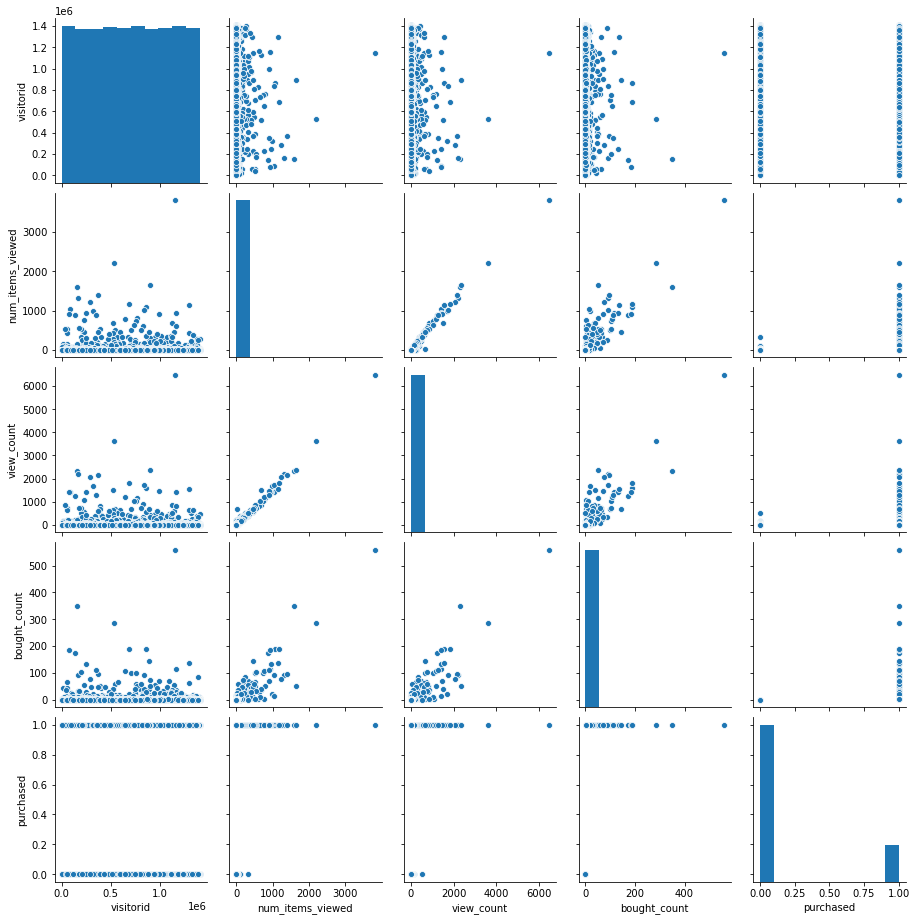

In [85]:
sns.pairplot(main_df)

In [94]:
main_df.corr(method ='pearson')

,visitorid,num_items_viewed,view_count,bought_count,purchased
visitorid,1.000000,-0.003347,-0.003134,-0.001263,0.004727
num_items_viewed,-0.003347,1.000000,0.991141,0.870846,0.102229
view_count,-0.003134,0.991141,1.000000,0.869608,0.113422
bought_count,-0.001263,0.870846,0.869608,1.000000,0.191290
purchased,0.004727,0.102229,0.113422,0.191290,1.000000


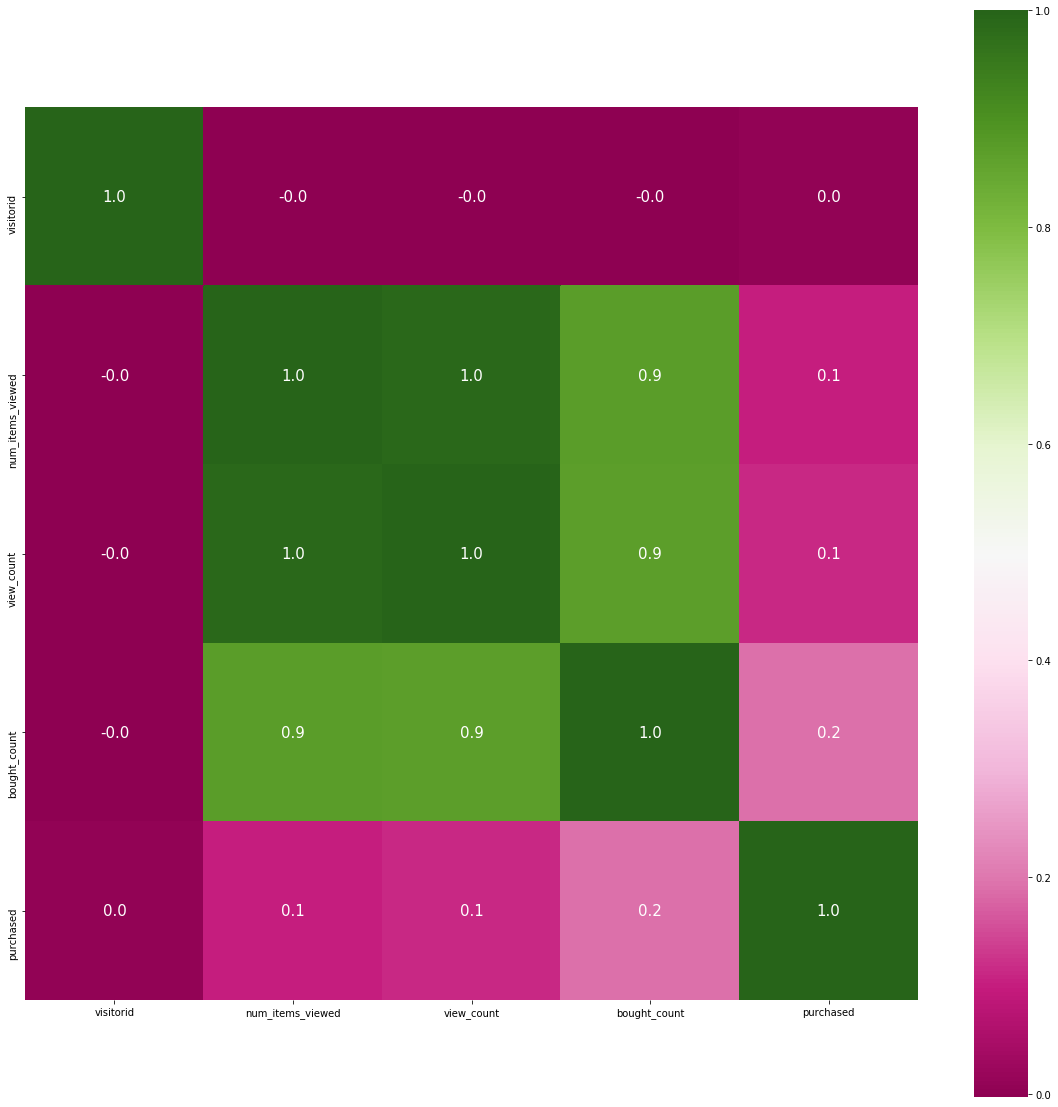

In [97]:
corr = main_df.corr()
corr.shape
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='PiYG')

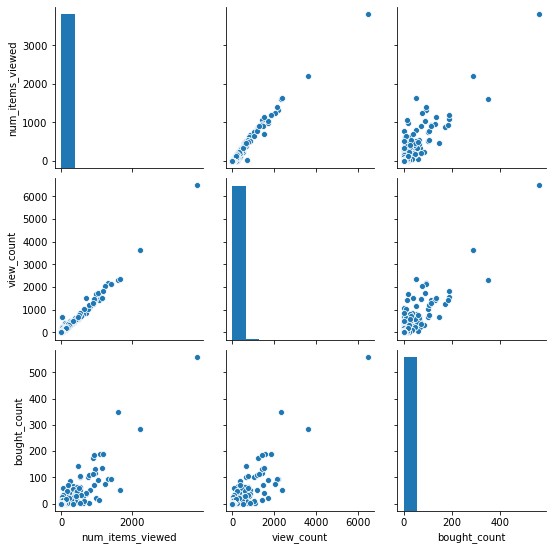

In [90]:
#Plot the data with out correlated variables

import seaborn as sns

sns.pairplot(main_df, x_vars = ['num_items_viewed', 'view_count', 'bought_count'],y_vars = ['num_items_viewed', 'view_count', 'bought_count'])

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> We separate the features (drop visitorid since it's categorical data and bought count) and the target (which is whether the visitor bought something or not) </font> </i>
    </i></u></b> </font>

In [91]:
main_df.to_csv('Mainfile.csv',index=False)

In [92]:
main_df1=pd.read_csv('Mainfile.csv')

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X = main_df1.drop(['purchased','visitorid','bought_count'], axis = 'columns')



y = main_df1.purchased

In [94]:
X.head()

,num_items_viewed,view_count
0,1,1
1,9,10
2,1,1
3,1,1
4,1,1


In [95]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: purchased, dtype: int64

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.7)

In [97]:
logreg = LogisticRegression()

In [98]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [99]:
# Let's now use the model to predict the test features
y_pred_class = logreg.predict(X_test)

In [100]:
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy =  0.8503


our model's accuracy in predicting buying visitors is around 85%

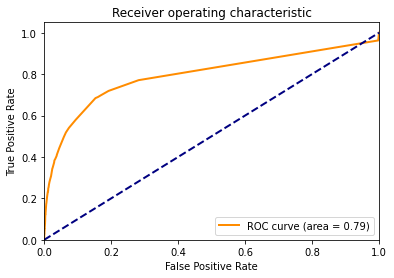

In [101]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()


The graph above shows the accuracy of our binary classifier (Logistic Regression). Just means that the closer the orange curve leans to the top left hand part of the graph, the better the accuracy.

In [102]:
X1 = main_df1.drop(['purchased', 'visitorid', 'bought_count'], axis = 'columns')
y1 = main_df1.purchased

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=123)

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

In [105]:
### Logistic regression classifier model
log_model = LogisticRegression()
dtree_model = DecisionTreeClassifier()

In [106]:
ensemble = VotingClassifier(estimators=[('lr', log_model), ('dtree', dtree_model)], voting='hard')

In [107]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dtree', DecisionTreeClassifier())])

In [108]:
#Measure the accuracy of the each of the models on test data.
from sklearn.metrics import accuracy_score

In [109]:
for model in (log_model, dtree_model, ensemble):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(model.__class__.__name__, accuracy_score(y_test, predictions))

LogisticRegression 0.8561244329228775
DecisionTreeClassifier 0.8649546338302009
VotingClassifier 0.8532080362929358


#### Bagging classifier model

In [111]:
from sklearn.ensemble import BaggingClassifier
bagged_model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

In [112]:
bagged_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

In [113]:
predictions = bagged_model.predict(X_test)

In [114]:
#Measure the accuracy of the model on test data.
accuracy_score(y_test, predictions)

0.8628483473752431

#### Random forest model

In [116]:
#Create a Random Forest Classifier ensemble with 500 Decision Tree classifiers.

from sklearn.ensemble import RandomForestClassifier

In [117]:
rf_model = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [118]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [119]:
predictions = rf_model.predict(X_test)

In [120]:
#Measure the accuracy of the model on test data.
accuracy_score(y_test, predictions)

0.8665748541801686

In [121]:
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [122]:
print(classification_report(y_test, predictions)) 

print(confusion_matrix(y_test, predictions)) 

print(accuracy_score(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     10024
           1       0.73      0.47      0.57      2320

    accuracy                           0.87     12344
   macro avg       0.81      0.71      0.74     12344
weighted avg       0.86      0.87      0.85     12344

[[9617  407]
 [1240 1080]]
0.8665748541801686


### (II) Collaborative Recommendation using Collaborative Topic Poisson Factorization

In [132]:
events = pd.read_csv("events.csv",na_values=[""," ","NA","N/A"])

In [133]:
events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

,UserId,ItemId,Count
0,0,67045,1
1,0,285930,1
2,0,357564,1
3,1,72028,1
4,2,216305,2


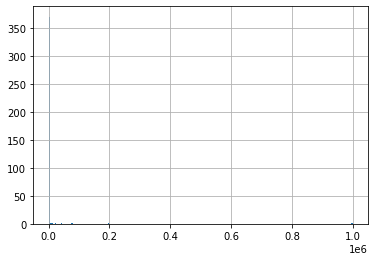

In [134]:
%matplotlib inline

equiv = {
    'view':1,
    'addtocart':3,
    'transaction':3
}
events['count']=events.event.map(equiv)
events.groupby('visitorid')['count'].sum().value_counts().hist(bins=200)
events = events.groupby(['visitorid','itemid'])['count'].sum().to_frame().reset_index()
events.rename(columns={'visitorid':'UserId', 'itemid':'ItemId', 'count':'Count'}, inplace=True)
events.head()

In [135]:
from sklearn.model_selection import train_test_split

events_train, events_test = train_test_split(events, test_size=.2, random_state=1)
del events

## In order to find users and items with at least 3 interactions each,
## it's easier and faster to use a simple heuristic that first filters according to one criteria,
## then, according to the other, and repeats.
## Finding a real subset of the data in which each item has strictly >= 3 users,
## and each user has strictly >= 3 items, is a harder graph partitioning or optimization
## problem. For a similar example of finding such subsets see also:
## http://nbviewer.ipython.org/github/david-cortes/datascienceprojects/blob/master/optimization/dataset_splitting.ipynb
users_filter_out = events_train.groupby('UserId')['ItemId'].agg(lambda x: len(tuple(x)))
users_filter_out = np.array(users_filter_out.index[users_filter_out < 3])

items_filter_out = events_train.loc[~np.in1d(events_train.UserId, users_filter_out)].groupby('ItemId')['UserId'].agg(lambda x: len(tuple(x)))
items_filter_out = np.array(items_filter_out.index[items_filter_out < 3])

users_filter_out = events_train.loc[~np.in1d(events_train.ItemId, items_filter_out)].groupby('UserId')['ItemId'].agg(lambda x: len(tuple(x)))
users_filter_out = np.array(users_filter_out.index[users_filter_out < 3])

events_train = events_train.loc[~np.in1d(events_train.UserId.values, users_filter_out)]
events_train = events_train.loc[~np.in1d(events_train.ItemId.values, items_filter_out)]
events_test = events_test.loc[np.in1d(events_test.UserId.values, events_train.UserId.values)]
events_test = events_test.loc[np.in1d(events_test.ItemId.values, events_train.ItemId.values)]

print(events_train.shape)
print(events_test.shape)

(381963, 3)
(68490, 3)


In [136]:
iteminfo = pd.read_csv("item_properties_part1.csv")
iteminfo2 = pd.read_csv("item_properties_part2.csv")
iteminfo = iteminfo.append(iteminfo2, ignore_index=True)
iteminfo.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [137]:
iteminfo = iteminfo.loc[iteminfo.property.isin(('888','283'))]
iteminfo = iteminfo.loc[iteminfo.groupby(['itemid','property'])['timestamp'].idxmax()]
iteminfo.reset_index(drop=True, inplace=True)
iteminfo.head()

,timestamp,itemid,property,value
0,1431226800000,0,283,66094 372274 478989
1,1433041200000,0,888,478989
2,1435460400000,1,283,513325 1020281 1204938 172646 72261 30603 8980...
3,1442113200000,1,888,172646 1154859
4,1431226800000,2,283,822092 325894 504272 147366 343631 648485 n600...


Note that for simplicity we are completely ignoring the categories (these are easily incorporated e.g. by adding a count of +1 for each category to which an item belongs) and important factors such as the price. We are also completely ignoring all the other fields.

In [138]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix
import re

def concat_fields(x):
    x = list(x)
    out = x[0]
    for i in x[1:]:
        out += " " + i
    return out

class NonNumberTokenizer(object):
    def __init__(self):
        pass
    def __call__(self, txt):
        return [i for i in txt.split(" ") if bool(re.search("^\d", i))]

iteminfo = iteminfo.groupby('itemid')['value'].agg(lambda x: concat_fields(x))

t = CountVectorizer(tokenizer=NonNumberTokenizer(), stop_words=None,
                    dtype=np.int32, strip_accents=None, lowercase=False)
bag_of_words = t.fit_transform(iteminfo)

bag_of_words = coo_matrix(bag_of_words)
bag_of_words = pd.DataFrame({
    'ItemId' : iteminfo.index[bag_of_words.row],
    'WordId' : bag_of_words.col,
    'Count' : bag_of_words.data
})
del iteminfo
bag_of_words.head()

,ItemId,WordId,Count
0,0,245598,1
1,0,164052,1
2,0,194496,2
3,1,204103,1
4,1,5710,1


In this case, we will not filter it out by only items that were in the training set, as other items can still be used to get better latent factors.

Using a small step size for the updates for the parameters obtained from hierarchical Poisson factorization at the beginning, which then grows to one with increasing iteration numbers , all the items for which there are either descriptions or user clicks, and another that uses all the items for which there are descriptions to initialize the item-related parameters but discards the ones without clicks (can only make recommendations for items that users have clicked).

In [140]:
print(events_train.shape)
print(events_test.shape)
print(bag_of_words.shape)

(381963, 3)
(68490, 3)
(7676561, 3)


   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Bag of words are nearly 3 times that of events in training dataset </font> </i>
    </i></u></b> </font>

In [17]:
#Model fitting

%%time
from ctpfrec import CTPF

recommender_all_items = CTPF(k=70, step_size=lambda x: 1-1/np.sqrt(x+1),
                   standardize_items=True, initialize_hpf=True, reindex=True,
                   missing_items='include', allow_inconsistent_math=True, random_seed=1)
recommender_all_items.fit(counts_df=events_train.copy(), words_df=bag_of_words.copy())

*****************************************
Collaborative Topic Poisson Factorization
*****************************************

Number of users: 65913
Number of items: 418301
Number of words: 342260
Latent factors to use: 70

Initializing parameters...
Initializing Theta and Beta through HPF...

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 417053
Number of items: 342260
Latent factors to use: 70

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | Norm(Theta_{10} - Theta_{0}): 3372.55566
Iteration 20 | Norm(Theta_{20} - Theta_{10}): 11.61354
Iteration 30 | Norm(Theta_{30} - Theta_{20}): 8.86025
Iteration 40 | Norm(Theta_{40} - Theta_{30}): 4.52295
Iteration 50 | Norm(Theta_{50} - Theta_{40}): 3.12306
Iteration 60 | Norm(Theta_{60} - Theta_{50}): 2.39490
Iteration 70 | Norm(Theta_{70} - Theta_{60}): 1.99581
Iteration 80 | Norm(Theta_{80} - Theta_{70}): 1.722

In [ ]:
%%time
recommender_clicked_items_only = CTPF(k=70, step_size=lambda x: 1-1/np.sqrt(x+1),
                   standardize_items=True, initialize_hpf=True, reindex=True,
                   missing_items='exclude', allow_inconsistent_math=True, random_seed=1)
recommender_clicked_items_only.fit(counts_df=events_train.copy(), words_df=bag_of_words.copy())

*****************************************
Collaborative Topic Poisson Factorization
*****************************************



g:\aws\envs\sallu\lib\site-packages\ctpfrec\__init__.py:475: UserWarning: Some words are associated only with items that are in 'words_df' but not in 'counts_df'. These will be used to initialize Beta but will be excluded from the final model. If you still wish to include them in the model, use 'missing_items='include''. For information about which words are used by the model, see the attribute 'word_mapping_'.
  warnings.warn(msg)


Number of users: 65913
Number of items: 39578
Number of words: 67980
Latent factors to use: 70

Initializing parameters...
Initializing Theta and Beta through HPF...

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 417053
Number of items: 342260
Latent factors to use: 70

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | Norm(Theta_{10} - Theta_{0}): 3372.55566
Iteration 20 | Norm(Theta_{20} - Theta_{10}): 11.61372
Iteration 30 | Norm(Theta_{30} - Theta_{20}): 8.86334
Iteration 40 | Norm(Theta_{40} - Theta_{30}): 4.52312


Most of the time here was spent in fitting the model to items that no user in the training set had clicked. 

#### 3. Model with all items

In [19]:
events_test['Predicted'] = recommender_all_items.predict(user=events_test.UserId, item=events_test.ItemId)
events_test['RandomItem'] = np.random.choice(events_train.ItemId.unique(), size=events_test.shape[0])
events_test['PredictedRandom'] = recommender_all_items.predict(user=events_test.UserId,
                                                               item=events_test.RandomItem)
print("Average prediction for combinations in test set: ", events_test.Predicted.mean())
print("Average prediction for random combinations: ", events_test.PredictedRandom.mean())

Average prediction for combinations in test set:  0.019600492
Average prediction for random combinations:  0.0054697306


In [20]:
from sklearn.metrics import roc_auc_score

was_clicked = np.r_[np.ones(events_test.shape[0]), np.zeros(events_test.shape[0])]
score_model = np.r_[events_test.Predicted.values, events_test.PredictedRandom.values]
roc_auc_score(was_clicked[~np.isnan(score_model)], score_model[~np.isnan(score_model)])

0.6841627160753907

In [21]:
np.corrcoef(events_test.Count[~events_test.Predicted.isnull()], events_test.Predicted[~events_test.Predicted.isnull()])[0,1]

0.11600350333412814

In [23]:
events_test['Predicted'] = recommender_clicked_items_only.predict(user=events_test.UserId, item=events_test.ItemId)
events_test['PredictedRandom'] = recommender_clicked_items_only.predict(user=events_test.UserId,
                                                                        item=events_test.RandomItem)
print("Average prediction for combinations in test set: ", events_test.Predicted.mean())
print("Average prediction for random combinations: ", events_test.PredictedRandom.mean())

Average prediction for combinations in test set:  0.03456579
Average prediction for random combinations:  0.008820312


In [24]:
was_clicked = np.r_[np.ones(events_test.shape[0]), np.zeros(events_test.shape[0])]
score_model = np.r_[events_test.Predicted.values, events_test.PredictedRandom.values]
roc_auc_score(was_clicked, score_model)

0.6948044522604617

In [25]:
np.corrcoef(events_test.Count, events_test.Predicted)[0,1]

0.07917870489276459

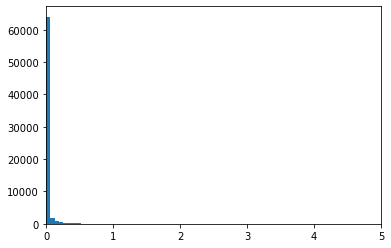

In [26]:
_ = plt.hist(events_test.Predicted, bins=200)
plt.xlim(0,5)
plt.show()

#### 4. Comparison to model without item information

A natural benchmark to compare this model is to is a Poisson factorization model without any item side information - here is the comparison with a Hierarchical Poisson factorization model with the same metrics as above:

%%time
from hpfrec import HPF

recommender_no_sideinfo = HPF(k=70)
recommender_no_sideinfo.fit(events_train.copy())

In [44]:
%%time 
from hpfrec import HPF

Wall time: 0 ns


In [46]:
recommender_no_sideinfo = HPF(k=70) 
recommender_no_sideinfo.fit(events_train.copy())

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 65913
Number of items: 39578
Latent factors to use: 70

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -4634120 | train rmse: 2.8446
Iteration 20 | train llk: -4555630 | train rmse: 2.8280
Iteration 30 | train llk: -4524700 | train rmse: 2.8233
Iteration 40 | train llk: -4507177 | train rmse: 2.8211
Iteration 50 | train llk: -4495517 | train rmse: 2.8204
Iteration 60 | train llk: -4487038 | train rmse: 2.8199
Iteration 70 | train llk: -4479502 | train rmse: 2.8195
Iteration 80 | train llk: -4472340 | train rmse: 2.8192
Iteration 90 | train llk: -4465921 | train rmse: 2.8188
Iteration 100 | train llk: -4460817 | train rmse: 2.8182


Optimization finished
Final log-likelihood: -4460817
Final RMSE: 2.8182
Minutes taken (optimization part): 3.0



In [47]:
events_test_comp = events_test.copy()
events_test_comp['Predicted'] = recommender_no_sideinfo.predict(user=events_test_comp.UserId, item=events_test_comp.ItemId)
events_test_comp['PredictedRandom'] = recommender_no_sideinfo.predict(user=events_test_comp.UserId,
                                                                      item=events_test_comp.RandomItem)
print("Average prediction for combinations in test set: ", events_test_comp.Predicted.mean())
print("Average prediction for random combinations: ", events_test_comp.PredictedRandom.mean())

Average prediction for combinations in test set:  0.015964039
Average prediction for random combinations:  0.007219164


In [48]:
was_clicked = np.r_[np.ones(events_test_comp.shape[0]), np.zeros(events_test_comp.shape[0])]
score_model = np.r_[events_test_comp.Predicted.values, events_test_comp.PredictedRandom.values]
roc_auc_score(was_clicked, score_model)

0.6775818618770495

In [49]:
np.corrcoef(events_test_comp.Count, events_test_comp.Predicted)[0,1]

0.046057735665537655

- As can be seen, adding the side information and widening the catalog to include more items using only their text descriptions (no clicks) results in an improvemnet over all 3 metrics, especially correlation with number of clicks.

- More important than that however, is its ability to make recommendations from a far wider catalog of items, which in practice can make a much larger difference in recommendation quality than improvement in typicall offline metrics.

 Making recommendations
The package provides a simple API for making predictions and Top-N recommended lists. These Top-N lists can be made among all items, or across some user-provided subset only, and you can choose to discard items with which the user had already interacted in the training set.


In [50]:
users_many_events = events_train.groupby('UserId')['ItemId'].agg(lambda x: len(tuple(x)))
users_many_events = np.array(users_many_events.index[users_many_events > 20])

np.random.seed(1)
chosen_user = np.random.choice(users_many_events)
chosen_user

1362222

In [51]:
%%time
recommender_all_items.topN(chosen_user, n=20)

Wall time: 51.9 ms


array([461686,   9877, 119736, 257040, 312728, 241555, 320130, 325310,
        29196, 309778, 234255, 445351, 409804,  38965, 303828, 219512,
        37029, 190000, 455183, 384302], dtype=int64)

(These numbers represent the IDs of the items being recommended as they appeared in the events_train data frame)

In [52]:
%%time
recommender_clicked_items_only.topN(chosen_user, n=20)

Wall time: 5.98 ms


array([119736, 234255, 231482, 355994, 441852, 118914, 456056, 204494,
        12217, 465522, 454818,  64951, 439963, 188051, 213834, 116624,
       455183, 277490,  63543, 389135], dtype=int64)

In [53]:
%%time
recommender_no_sideinfo.topN(chosen_user, n=20)

Wall time: 23.9 ms


array([234255, 231482, 325852, 120098, 125440, 140527, 116624,  60980,
       287696, 395435, 340960,  67438, 118914, 245085, 228075, 312781,
       128908, 257200, 368403,  99675], dtype=int64)

   
###### <font color=brown> <b><u><i> Key Insights :-
- <i><font color=brown> Recommender systems for three categories are calculated - all items, clicked items and no-info items </font> </i>
    </i></u></b> </font>

### (III) Collaborative Recommendation using LightFM

Using LightFM a popular recommendation algorithms which makes possible to incorporate both item and user metadata into the traditional matrix factorization algorithms.

In [141]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix
from sklearn import preprocessing

g:\aws\envs\sallu\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [143]:
events = pd.read_csv("events.csv",na_values=[""," ","NA","N/A"])

In [144]:
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
events = events[['visitorid','itemid','event', 'date']]
events.head(5)

,visitorid,itemid,event,date
0,1161039,7145,view,2015-05-03
1,589451,330253,view,2015-05-03
2,540933,77740,view,2015-05-03
3,1118945,105950,view,2015-05-03
4,423949,412324,view,2015-05-03


In [145]:
start_date = '2015-5-3'
end_date = '2015-5-18'
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events = events[(events.date >= fd(start_date)) & (events.date <= fd(end_date))]

In [146]:
split_point = np.int(np.round(events.shape[0]*0.8))
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid'])) & (events_test['itemid'].isin(events_train['itemid']))]

In [147]:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()

for k in id_cols:
    cate_enc=preprocessing.LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k]=cate_enc.transform(events_test[k].values)

In [148]:
ratings = dict()

cate_enc=preprocessing.LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)

In [149]:
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

In [150]:
rate_matrix = dict()
rate_matrix['train'] = coo_matrix((ratings['train'], (trans_cat_train['visitorid'], trans_cat_train['itemid'])), shape=(n_users,n_items))
rate_matrix['test'] = coo_matrix((ratings['test'], (trans_cat_test['visitorid'], trans_cat_test['itemid'])), shape=(n_users,n_items))

In [151]:
model = LightFM(no_components=10, loss='warp')
model.fit(rate_matrix['train'], epochs=100, num_threads=8)

In [152]:
auc_score(model, rate_matrix['train'], num_threads=8).mean()

0.998633

In [153]:
auc_score(model, rate_matrix['test'], num_threads=10).mean()

0.8168923

In [165]:
from lightfm import LightFM
from lightfm.data import Dataset
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import os

In [166]:
# Set Working directory
#os.chdir(r'C:\Users\SHALESH\Desktop\Final_Project _ML_Dataset')

In [167]:
events = pd.read_csv("events.csv",na_values=[""," ","NA","N/A"])
category_tree = pd.read_csv("category_tree.csv",na_values=[""," ","NA","N/A"])
item_properties_part1 = pd.read_csv("item_properties_part1.csv",na_values=[""," ","NA","N/A"])
item_properties_part2 = pd.read_csv("item_properties_part2.csv",na_values=[""," ","NA","N/A"])
item_properties_part = pd.concat([item_properties_part1, item_properties_part2])

In [168]:
def TransfromData(category_tree, events,item_properties_part):
    data_raw = events[['visitorid','event','itemid']]
    data = data_raw.copy()
    transfrom_rating = []
    for event in data.event:
        if(event == 'view'):
            transfrom_rating.append(1)
        if(event == 'addtocart'):
            transfrom_rating.append(2)
        if(event == 'transaction'):
            transfrom_rating.append(3)
    data['rating']= transfrom_rating
    return data[['visitorid','itemid','rating']]
def RedundantData_VisistorOnlyApper(transform_data):
    data_examining = transform_data.copy()
    visitorid_size = data_examining.groupby(['visitorid']).size().reset_index(name='Size').sort_values("visitorid")
    visitorid_only_appear = visitorid_size[visitorid_size['Size']== 1]['visitorid'].tolist()
    data_surprise_remove_only_appear = data_examining[~data_examining['visitorid'].isin(visitorid_only_appear)]
    return data_surprise_remove_only_appear
def RedundantData_DropDuplicatesFeature(data_surprise_remove_only_appear):
    drop_feature = ['visitorid','itemid','rating']
    data_surprise_drop_duplicates_3_feature = data_surprise_remove_only_appear.drop_duplicates(subset=drop_feature)
    return data_surprise_drop_duplicates_3_feature
def RedundantData_SelectMaxRating(data_surprise_drop_duplicates_3_feature):
    drop_feature = ['visitorid','itemid']
    data_examining = data_surprise_drop_duplicates_3_feature.copy()
    data_seclect_max_rating = data_examining.groupby(drop_feature).max()['rating'].reset_index()
    return data_seclect_max_rating

In [169]:
category_tree, events,item_properties_part
transform_data = TransfromData(category_tree, events,item_properties_part)
data_surprise_remove_only_appear = RedundantData_VisistorOnlyApper(transform_data)
data_surprise_drop_duplicates = RedundantData_DropDuplicatesFeature(data_surprise_remove_only_appear)
data_seclect_max_rating = RedundantData_SelectMaxRating(data_surprise_drop_duplicates)

In [170]:
data_seclect_max_rating.head()

,visitorid,itemid,rating
0,0,67045,1
1,0,285930,1
2,0,357564,1
3,2,216305,1
4,2,259884,1


In [171]:
data_seclect_max_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143619 entries, 0 to 1143618
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   visitorid  1143619 non-null  int64
 1   itemid     1143619 non-null  int64
 2   rating     1143619 non-null  int64
dtypes: int64(3)
memory usage: 26.2 MB


In [172]:
data = data_seclect_max_rating.copy()

In [173]:
data.head()

,visitorid,itemid,rating
0,0,67045,1
1,0,285930,1
2,0,357564,1
3,2,216305,1
4,2,259884,1


Model building

- Interaction and weigth: prepare to add the model
- Create query data: users are not persistent, so it is necessary to create a conversion

In [174]:
def ProcessData(data_form_pandas):
    data_form_pandas.sort_values(by =['visitorid','itemid'], inplace = True)
    data_form_pandas.reset_index(drop=True, inplace = True)
    return data_form_pandas
def Onehot(list_sample):
    if(list_sample != 0):
        return 1
    else:
        return 0
def CountSame(frist_list, second_list):
    return list(set(frist_list).intersection(set(second_list)))
def InteractionTransform(transform_data):
    data_numpy = np.array(transform_data)
    data_lightfm = Dataset()
    data_lightfm.fit(users= transform_data['visitorid'].unique(),items= transform_data['itemid'].unique())
    interactions, weigths = data_lightfm.build_interactions(
        (feature[0],feature[1],feature[2]) for feature in data_numpy)
    return interactions, weigths
def MergeInteraction(original_data):
    interaction, weight = InteractionTransform(original_data)
    interaction_user = interaction.row
    interaction_item = interaction.col
    original_data['transform user'] = interaction_user
    original_data['transform item'] = interaction_item
    query_data = original_data.copy()
    return query_data
def BuildLightFmModel(data_form_pandas):
    data = data_form_pandas.copy()
    model = LightFM(loss='warp')
    interaction, weight = InteractionTransform(data)
    model.fit_partial(interactions= interaction, sample_weight= weight)
    return model

In [175]:
data_train, data_test = train_test_split(data, test_size = 0.25)

Due to too many data we only build with data_test

In [176]:
data_test.head()

,visitorid,itemid,rating
635591,778794,34857,1
587483,720167,110760,1
944825,1154836,273693,1
233963,286616,215776,1
828001,1012735,252854,1


In [177]:
dataset = data_test.copy()

In [178]:
data_tuning = ProcessData(dataset)
interactions, weights = InteractionTransform(data_tuning)
query_data = MergeInteraction(data_tuning)
model_lightfm = BuildLightFmModel(data_tuning)

In [179]:
query_data.head()

,visitorid,itemid,rating,transform user,transform item
0,2,216305,1,0,0
1,6,344723,1,1,1
2,7,164941,1,2,2
3,13,320589,1,3,3
4,22,86411,1,4,4


In [180]:
model_lightfm

In [181]:
def PredictModel(lightfm_model, data_model, user_ids, verbose= False):
    query_data = MergeInteraction(data_model)
    query_user = query_data[query_data['visitorid'].isin(user_ids)]['transform user'].unique()
    count = 0
    original_item = []
    recommend_item = []
    item_same = []
    length_item_same = []
    for user_id in query_user:
        known_item = query_data[query_data['transform user'] == user_id]['itemid'].tolist()
        item_for_user = query_data['transform item'].unique().tolist()
        scores = lightfm_model.predict([user_id], item_for_user)
        top_items = query_data['itemid'][np.argsort(-scores)].tolist()
        if(verbose == True):
            print("User %s" % user_ids[count])
            print("     Known positives: ",known_item[:5])
            print("     Recommended: ",top_items[:5])
        count+= 1
        original_item.append(known_item[:5])
        recommend_item.append(top_items[:5])
        item_same.append(CountSame(known_item[:5], top_items[:5]))
        length_item_same.append(len(CountSame(known_item[:5], top_items[:5])))
        
    recommend = pd.DataFrame(user_ids, columns={'visitorid'})
    recommend['original item'] = original_item
    recommend['recommend item'] = recommend_item
    recommend['item same'] = item_same
    recommend['length'] = length_item_same
    recommend['one hot'] = recommend['length'].apply(lambda x: Onehot(x))
    return recommend       
def Accuracy(recommend_form_pandas):
    positive_user = recommend_form_pandas[recommend_form_pandas['length'] != 0].shape[0]
    return positive_user/recommend_form_pandas.shape[0]

In [182]:
user = dataset['visitorid'].unique().tolist()
user[:5]

[2, 6, 7, 13, 22]

In [183]:
user = query_data['visitorid'].unique().tolist()
user[:5]

[2, 6, 7, 13, 22]

In [184]:
recommend_data = PredictModel(model_lightfm, dataset, user[:500])

In [185]:
recommend_data.head()

,visitorid,original item,recommend item,item same,length,one hot
0,2,[216305],"[258968, 379481, 194735, 222323, 431783]",[],0,0
1,6,[344723],"[258968, 194735, 379481, 222323, 309778]",[],0,0
2,7,[164941],"[258968, 379481, 194735, 222323, 309778]",[],0,0
3,13,[320589],"[258968, 194735, 379481, 222323, 431783]",[],0,0
4,22,[86411],"[258968, 222323, 194735, 379481, 431783]",[],0,0


In [186]:
recommend_data[recommend_data['length'] != 0]

,visitorid,original item,recommend item,item same,length,one hot
71,479,[309778],"[258968, 309778, 194735, 379481, 222323]",[309778],1,1
376,2883,"[222323, 304528]","[258968, 379481, 222323, 431783, 194735]",[222323],1,1
380,2941,[258968],"[258968, 194735, 379481, 309778, 222323]",[258968],1,1
452,3395,[379481],"[258968, 222323, 194735, 379481, 309778]",[379481],1,1
460,3440,"[248327, 257040, 292444, 309778]","[258968, 309778, 379481, 194735, 431783]",[309778],1,1


Here, we get an list of all the items as per the original items with the recommended items list